In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 18 seconds. 440 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [8]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [12]:
model, ps, st = build_mlp_f32(args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#27#29"}, layer_3::WrappedFunction{:direct_call, var"#28#30"}, layer_4::PhasorDenseF32, layer_5::PhasorDenseF32}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#27#29"()), layer_3 = WrappedFunction{:direct_call}(var"#28#30"()), layer_4 = PhasorDenseF32((2, 128)), layer_5 = PhasorDenseF32((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.022104176 0.0044612987; 0.018899843 -0.097602904; … ; 0.13916312 -0.026716936; -0.21080711 0.04344049], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 

In [13]:
spk_model, _, _ = build_spiking_mlp_f32(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#31#32"}, layer_3::MakeSpiking, layer_4::PhasorDenseF32, layer_5::PhasorDenseF32}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#31#32"()), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0), 0.0), layer_4 = PhasorDenseF32((2, 128)), layer_5 = PhasorDenseF32((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.23785943 0.07556767; -0.06319771 -0.13431165; … ; -0.034689475 -0.026928129; 0.003453096 -0.018008614], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0,

In [14]:
y, _ = model(x, ps, st)

([-0.9817763821150324 0.9608504745002412 … 0.988495705492067 0.9902470023987128; -0.05301371739566239 -0.02237393807713747 … -0.12411457834933991 -0.05344759814113067], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [15]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [16]:
y_spk.train.offset

0.5

In [17]:
p_spk = train_to_phase(y_spk);

In [18]:
size(p_spk)

(10, 2, 256)

In [19]:
size(y)

(2, 256)

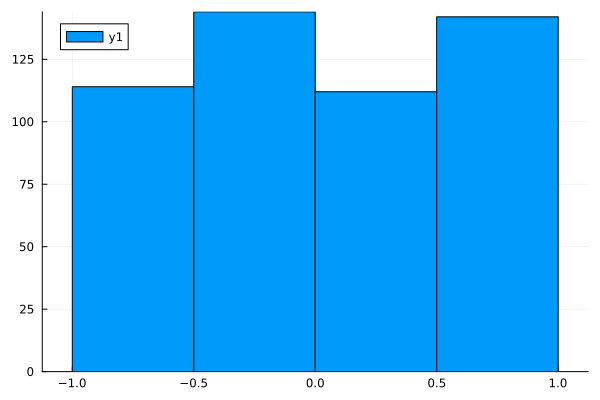

In [20]:
histogram(vec(p_spk[5,:,:]))

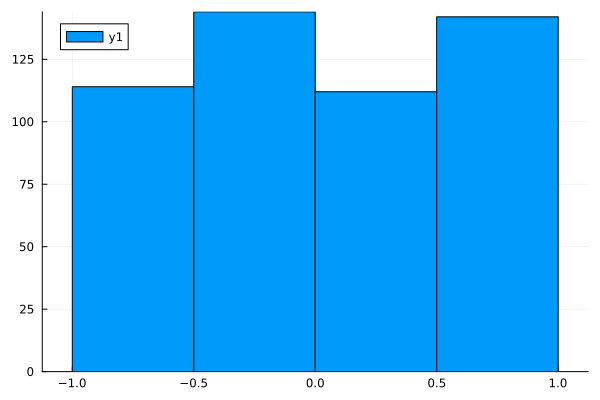

In [21]:
histogram(vec(p_spk[6,:,:]))

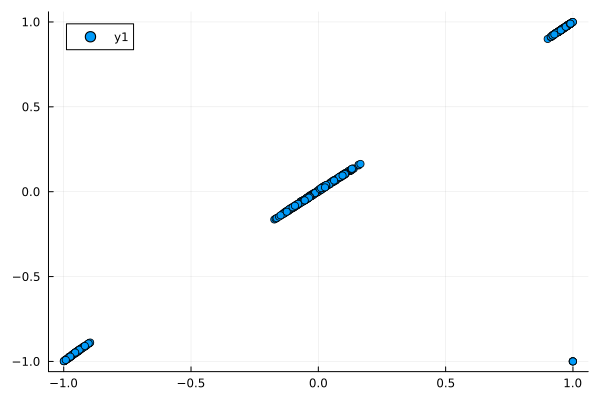

In [22]:
scatter(vec(y), vec(p_spk[5,:,:]))

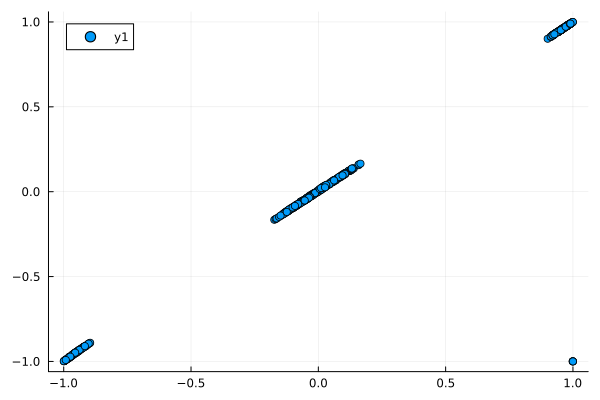

In [23]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [24]:
y |> size

(2, 256)

In [25]:
p_spk |> size

(10, 2, 256)

In [26]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9656482464101257
   0.966064819690745
   0.966168715054488
   0.9662140854629409
   0.9662388715542855
   0.966254160612351
   0.9662643276338768
   0.966271438940279
   0.775766415478151

In [27]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.9908471950548884, 1.0630748984159633, 0.9905551380330803, 1.0766145246985184, 0.9731242529108688, 1.0032917573064497, 0.9663085854422987, 0.9787531628156126, 0.9713270749366371, 0.9629774845645105  …  0.07648777984917188, 0.06970107719119514, 0.06322099151434121, 0.07144404338518345, 0.08431079889633096, 0.0683412535299722, 0.08027927839198575, 0.07636295000820074, 0.08231191425313512, 0.07115051150597658], (layer_1 = (bias = Float32[-0.19311337; 0.032255325;;], scale = Float32[0.8779886; 0.86476;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.029726405 0.005450398; 0.0030474064 -0.0987923; … ; 0.13381515 -0.018213345; -0.23493746 0.010465127], bias_real = Float32[0.9972189, 0.9993957, 1.0180831, 0.99410146, 0.9387196, 1.0125905, 0.9482612, 0.96657765, 1.0021291, 0.93901366  …  0.9695387, 0.97491854, 0.9927992, 1.0034686, 0.99651664, 1.0137789, 0.96429163, 0.98632425, 1.0063387, 0.97105455], bias_imag = Float32[-0.006742896, 0.0018289839, 0.001

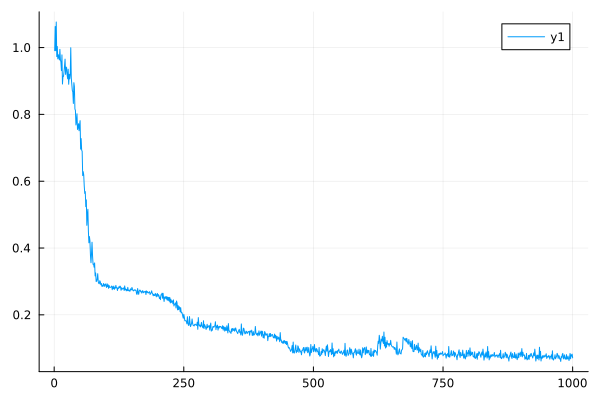

In [28]:
plot(losses)

In [29]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.07688961829998979, 0.966015625)

In [30]:
ps_train.layer_1

(bias = Float32[-0.19311337; 0.032255325;;], scale = Float32[0.8779886; 0.86476;;])

In [31]:
yt, _ = model(x, ps_train, st_train)

([-0.08181030788511776 0.2276075271466103 … 0.6239450321288773 0.5211915242854458; 0.3720728832112515 0.28828446265957103 … 0.11863731389919076 -0.010828116408798591], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [32]:
ps_train

(layer_1 = (bias = Float32[-0.19311337; 0.032255325;;], scale = Float32[0.8779886; 0.86476;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.029726405 0.005450398; 0.0030474064 -0.0987923; … ; 0.13381515 -0.018213345; -0.23493746 0.010465127], bias_real = Float32[0.9972189, 0.9993957, 1.0180831, 0.99410146, 0.9387196, 1.0125905, 0.9482612, 0.96657765, 1.0021291, 0.93901366  …  0.9695387, 0.97491854, 0.9927992, 1.0034686, 0.99651664, 1.0137789, 0.96429163, 0.98632425, 1.0063387, 0.97105455], bias_imag = Float32[-0.006742896, 0.0018289839, 0.0015918047, -0.018321814, 0.06524352, -1.974394f-5, -0.04765624, 0.06130107, 0.00021544188, -0.0142796775  …  -0.024790667, -0.05009507, -0.015145591, 0.008135866, -0.001427248, -0.007486141, -0.017518545, 0.016644582, 0.02018885, -0.041801475]), layer_5 = (weight = Float32[0.8992998 -0.80288875 … -0.81191874 -0.8740716; -0.34288734 -0.4235808 … -0.061715588 0.65323997], bias_real = Float32[1.0278208, 0.9731049], bias

In [33]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [34]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

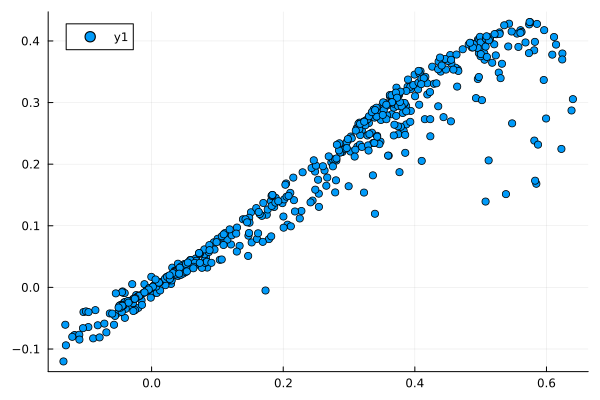

In [35]:
scatter(vec(yt), vec(pt[5,:,:]))

In [36]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 -0.12215820323912044
  0.838676035380807
  0.90362098137843
  0.9403238978195553
  0.962360615658863
  0.9760295567074658
  0.9845364883303359
  0.9897390072909563
  0.9928501918301733
  0.9932641142331348

# Test FP64

In [37]:
model, ps, st = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#21#23"}, layer_3::WrappedFunction{:direct_call, var"#22#24"}, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#21#23"()), layer_3 = WrappedFunction{:direct_call}(var"#22#24"()), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03539858 -0.090186074; -0.083128124 -0.037502654; … ; 0.032928616 0.15783635; 0.019997993 -0.14791685], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f

In [38]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#25#26"}, layer_3::MakeSpiking, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#25#26"()), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0), 0.0), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.094821975 0.07953794; 0.0360204 0.042711683; … ; -0.007802457 -0.12494608; -0.12408376 0.032318432], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f

In [39]:
x

2×256 adjoint(::Matrix{Float64}) with eltype Float64:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [40]:
y, _ = model(x, ps, st)

([0.7723185090820577 -0.8509214570145998 … 0.7539374386860844 0.9183012693392931; -0.9997130210259608 -0.9939237093850612 … 0.9897709176477776 0.9953183076653769], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [41]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [42]:
y_spk.train.offset

0.5

In [43]:
p_spk = train_to_phase(y_spk);

In [44]:
size(p_spk)

(10, 2, 256)

In [45]:
size(y)

(2, 256)

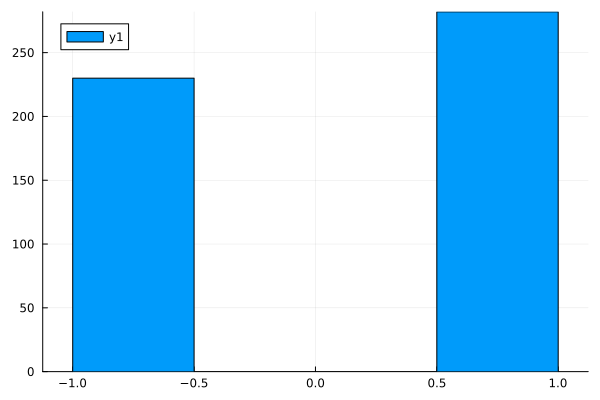

In [46]:
histogram(vec(p_spk[5,:,:]))

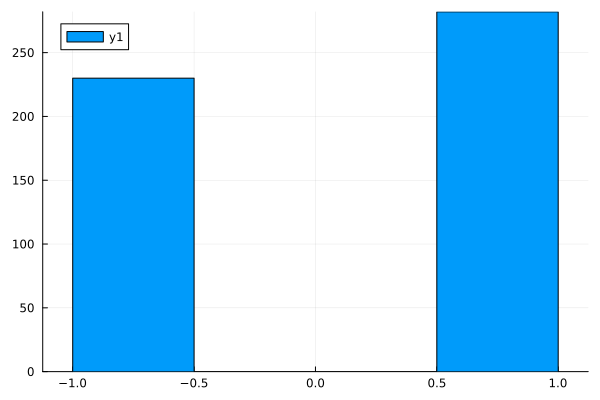

In [47]:
histogram(vec(p_spk[6,:,:]))

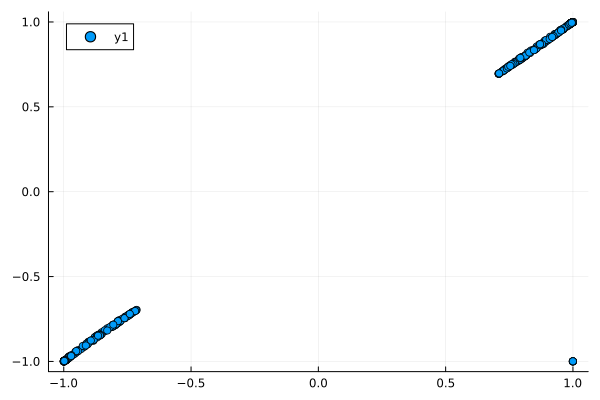

In [48]:
scatter(vec(y), vec(p_spk[5,:,:]))

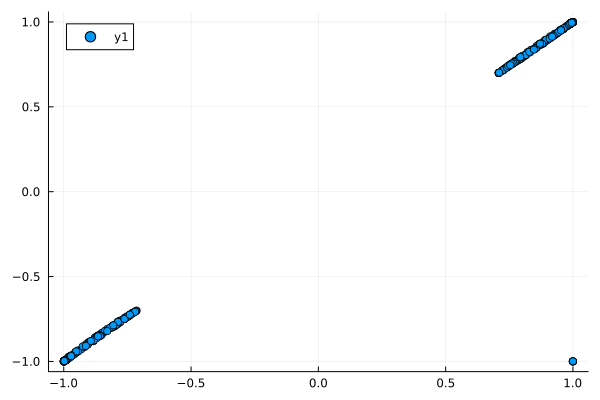

In [49]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [50]:
y |> size

(2, 256)

In [51]:
p_spk |> size

(10, 2, 256)

In [52]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9705371434097527
   0.9723613179917708
   0.9726374981312468
   0.9727375465648518
   0.9727870296198204
   0.9728157496667467
   0.9683826818898459
   0.9683970597551541
   0.48829222314302384

In [53]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[1.4389196937253537, 1.5097126293751602, 1.4951130198350777, 1.479677649817552, 1.472227813871818, 1.445709102543708, 1.4153193520960632, 1.3627386567114592, 1.455889637886158, 1.3681182492558794  …  0.10029650710455863, 0.1088849279932833, 0.10058990797510539, 0.10058013314231962, 0.10845876514575632, 0.09648720777250128, 0.10568253018521344, 0.09842447867306094, 0.10303511524707892, 0.10513167739128408], (layer_1 = (bias = Float32[0.2813287; -0.06776948;;], scale = Float32[0.80134577; 0.9579917;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.029882748 -0.06750979; -0.10916918 -0.08453599; … ; 0.023678018 0.23187485; -0.028731361 -0.14907588], bias = ComplexF32[1.0007823f0 + 0.013305447f0im, 0.99802506f0 - 0.024042072f0im, 1.0006409f0 - 0.009498147f0im, 1.0003463f0 - 0.006503719f0im, 0.9980384f0 - 0.023104412f0im, 0.9976499f0 + 0.05150933f0im, 0.9992413f0 - 0.012159227f0im, 0.99841243f0 - 0.033664893f0im, 0.99365f0 - 0.032637563f0im, 1.0010684f0 

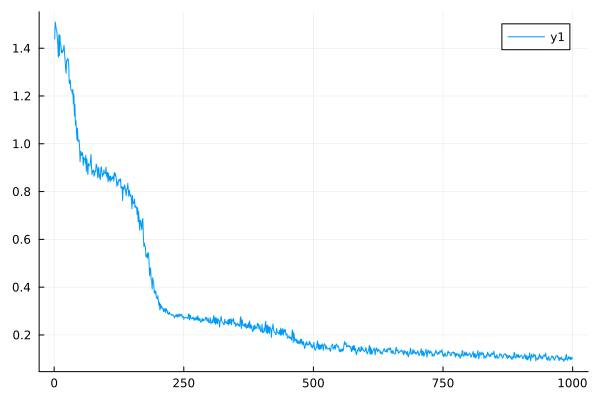

In [54]:
plot(losses)

In [55]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.09890138794957955, 0.95234375)

In [56]:
yt, _ = model(x, ps_train, st_train)

([0.06313671241737828 0.09993495807999193 … 0.4223004373282762 0.39921640736958797; 0.3195475650406057 0.287296184373822 … 0.18440377668180918 0.06939484540023677], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [57]:
ps_train

(layer_1 = (bias = Float32[0.2813287; -0.06776948;;], scale = Float32[0.80134577; 0.9579917;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.029882748 -0.06750979; -0.10916918 -0.08453599; … ; 0.023678018 0.23187485; -0.028731361 -0.14907588], bias = ComplexF32[1.0007823f0 + 0.013305447f0im, 0.99802506f0 - 0.024042072f0im, 1.0006409f0 - 0.009498147f0im, 1.0003463f0 - 0.006503719f0im, 0.9980384f0 - 0.023104412f0im, 0.9976499f0 + 0.05150933f0im, 0.9992413f0 - 0.012159227f0im, 0.99841243f0 - 0.033664893f0im, 0.99365f0 - 0.032637563f0im, 1.0010684f0 + 0.0052795038f0im  …  0.9983726f0 + 0.030282576f0im, 0.9988507f0 + 0.065336f0im, 0.9994231f0 - 0.033538856f0im, 1.0001827f0 + 0.02492978f0im, 0.9968043f0 - 0.052911744f0im, 0.995779f0 - 0.027762154f0im, 0.9991468f0 - 0.015185903f0im, 1.0008055f0 + 0.015471579f0im, 0.99440706f0 - 0.08147728f0im, 0.99891526f0 - 0.058583494f0im]), layer_5 = (weight = Float32[0.5842967 -1.025886 … 0.26484585 -0.25630683; 0.1431399

In [58]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [59]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

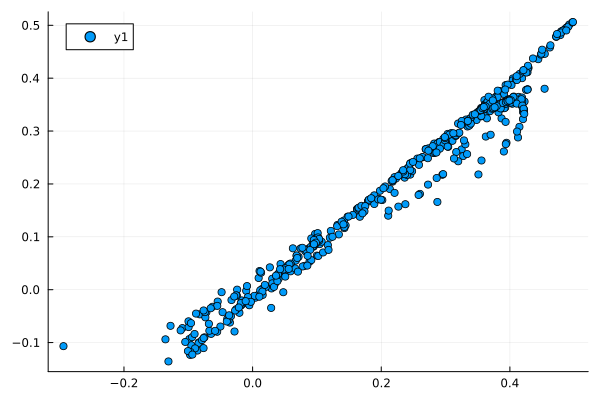

In [60]:
scatter(vec(yt), vec(pt[8,:,:]))

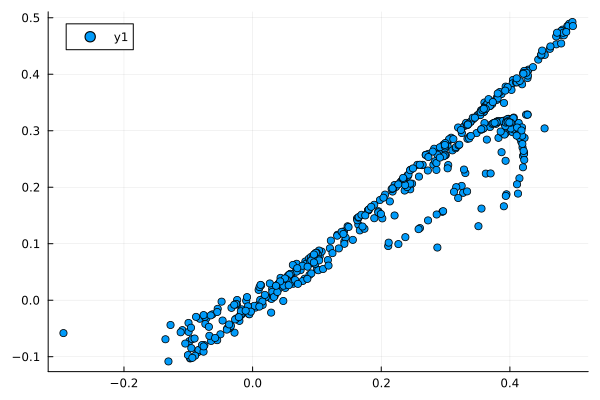

In [61]:
scatter(vec(yt), vec(pt[5,:,:]))

In [62]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 0.07885445994903807
 0.8165907802541365
 0.9037062724203025
 0.9438133935930989
 0.9648392623841578
 0.9767865504554288
 0.9839319375541534
 0.9883549798405326
 0.9911607973413836
 0.9761911010034086

In [63]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [64]:
p0, _ = to_phase(x, ps_phase, st_phase)

([0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

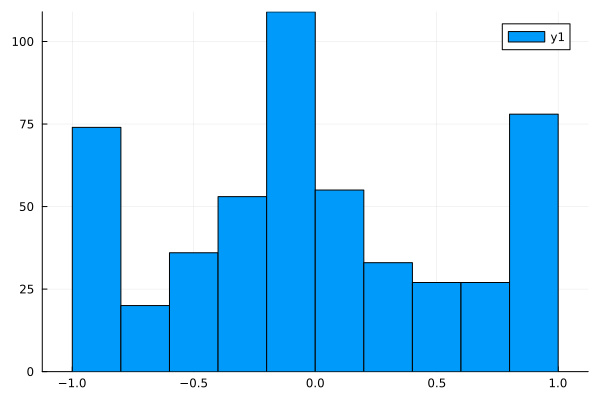

In [65]:
histogram(vec(p0))

In [66]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [67]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [68]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [69]:
using ChainRulesCore: ignore_derivatives

In [70]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [71]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#38"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

In [72]:
xfn(0.4)

2×256 Matrix{Float64}:
 0.0367008     0.0          5.11018e-138  …  4.11898e-169  0.0           0.0
 3.19094e-194  8.96151e-11  0.0              0.0           1.56768e-302  0.0

In [73]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [74]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#41#43"()),
    layer_3 = WrappedFunction{:direct_call}(var"#42#44"()),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [75]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.14626417 -0.12822406; -0.07246504 0.13014768; … ; -0.15992485 -0.017087603; -0.045535766 0.12945591], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [76]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#159"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#38"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}, Matrix{ComplexF32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.Stand

In [77]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args)[:,:,end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#45#48"()),
    layer_3 = WrappedFunction{:direct_call}(var"#46#49"()),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction{:direct_call}(var"#47#50"()),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [78]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.07644477 -0.1732005; -0.2002559 -0.016220696; … ; -0.09485025 0.16527054; -0.19838981 0.035082426], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.17474419 -0.0645531 … 1.3657668 1.0383359; -0.05546039 1.0400453 … 1.7833362 0.73285514], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [79]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.0010264554738580965 -0.0003114081231764934 … -0.0002702887506261169 0.00010117350361569354; 0.012551819796899007 -0.017218222595758267 … -0.015389028079984612 -0.012391872362617089], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [80]:
y_ode

2×256 Matrix{Float64}:
 -0.00102646  -0.000311408   0.00190271  …  -0.000270289   0.000101174
  0.0125518   -0.0172182    -0.00930531     -0.015389     -0.0123919

In [81]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.07644477 -0.1732005; -0.2002559 -0.016220696; … ; -0.09485025 0.16527054; -0.19838981 0.035082426], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.17474419 -0.0645531 … 1.3657668 1.0383359; -0.05546039 1.0400453 … 1.7833362 0.73285514], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [82]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

0.89243097891134

In [83]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 0.8924309940653881, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.00025975442 0.00012921152; -0.005297854 -0.0026894324; … ; -0.009347839 -0.004770402; -0.0038780826 -0.0019927807], bias = Float32[0.0037278645; -0.081251375; … ; -0.14511728; -0.06110235;;]), layer_5 = Float32[], layer_6 = (weight = Float32[2.0139096f-5 2.1761469f-5 … -8.212188f-6 1.6871018f-5; -0.0064941826 -0.006272068 … -0.0072836317 -0.006414538], bias_real = Float32[-4.436985f-6, -0.007316467], bias_imag = Float32[-0.003904503, -0.08712129])),))

In [84]:
solution_to_phase(y_sol, spk_args=spk_args)

128×256 Matrix{Float64}:
  0.00175442    0.000622506  -0.00267801   …   0.000528401   2.36502e-5
 -0.00143887    0.00029496    0.00221386       0.000299893   0.000531437
 -0.000903379   0.000209355   0.00146581       0.000214061   0.00036645
  0.00100378   -0.0019122    -0.000211329     -0.00170911   -0.00123457
  0.000396275   0.00155255   -0.00117833       0.00137512    0.000839175
 -0.00225204    9.22556e-5    0.00353255   …   0.000138929   0.000596248
 -0.000452965   7.51043e-5    0.000871125      8.68674e-5    0.000193191
 -0.000246466   0.00165591   -0.000285322      0.00147491    0.00103642
 -0.00206535    1.27219e-5    0.00329766       6.56938e-5    0.000510719
 -0.000592377   0.00121347    0.000464349      0.00109083    0.000862549
 -0.000516183  -0.0016018     0.00186977   …  -0.00138984   -0.000731258
  0.00183836    0.000904593  -0.00295228       0.000778007   0.000164352
  0.000378213   0.0012801    -0.0010053        0.00113462    0.000689669
  ⋮                           

In [85]:
mean(abs.(solution_to_phase(sol_model(x, ps_sol, st_sol)[1], spk_args=spk_args)))

0.0009932347839059657

In [86]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.14626417 -0.12822406; -0.07246504 0.13014768; … ; -0.15992485 -0.017087603; -0.045535766 0.12945591], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))